In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! cp -r "./drive/My Drive/dl/lab12/oregon_wildlife" "./"

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


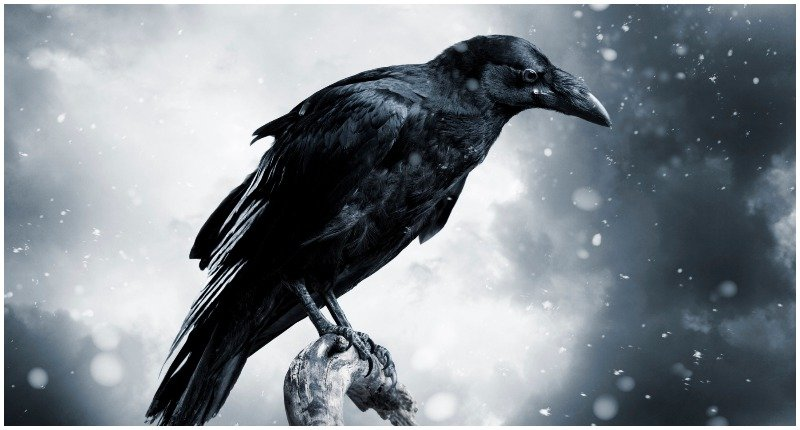

oregon_wildlife\raven\0923baa96dd05c63d5.jpg


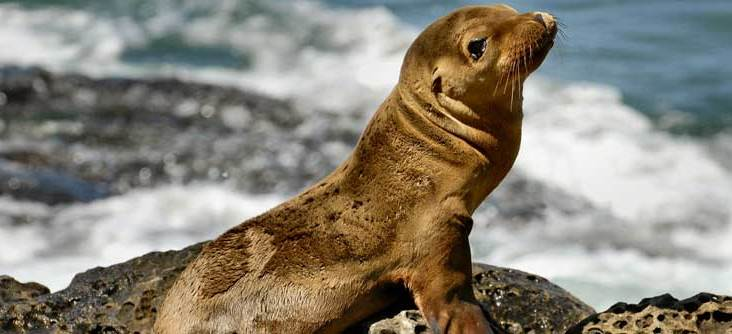

oregon_wildlife\sea_lions\c6139a25799be29966.jpg


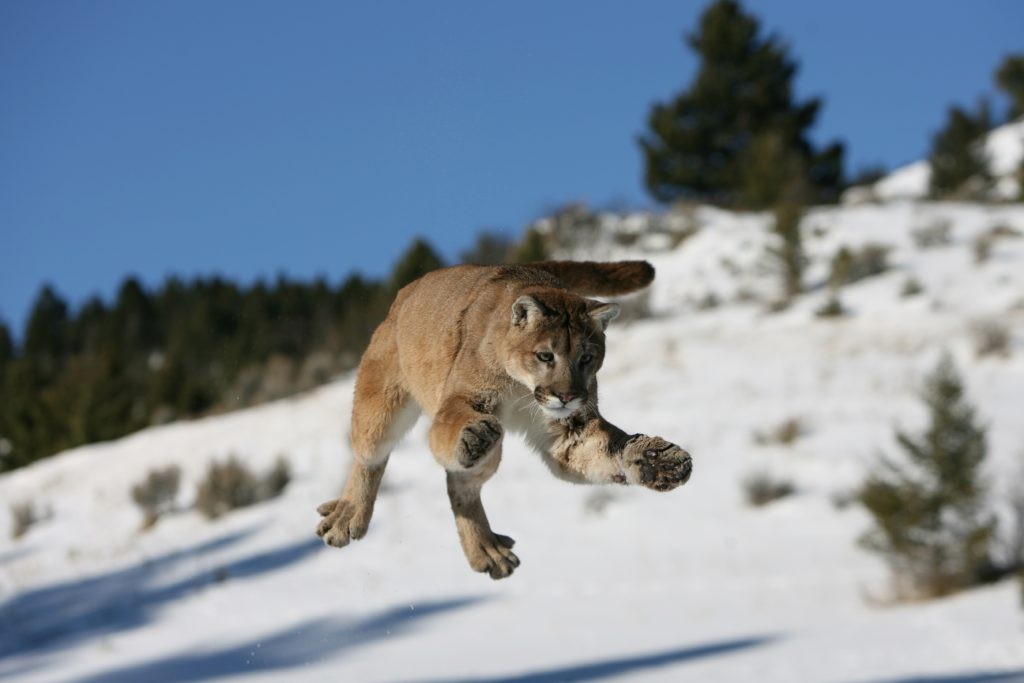

oregon_wildlife\cougar\f4a03f4b48ea9b2149.jpeg


In [7]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-1])

In [8]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [9]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [10]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [11]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [12]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [13]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [14]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

In [15]:
dataset_train

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int32)>

# Write Dataset into TFRecord

In [15]:
def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.numpy().ravel()))

# def _int32_feature(value):
#   return tf.train.Feature(int64_list=tf.train.Int32List(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def tf_serialize_to_string(img, label):
  features = {
      'img': _float_feature(img),
      'label': _int64_feature(label)
  }

  proto = tf.train.Example(features=tf.train.Features(feature=features))

  return proto.SerializeToString()

def tf_serialize_example(img, label):
  tf_string = tf.py_function(
      tf_serialize_to_string,
      (img, label),
      tf.string
  )

  return tf.reshape(tf_string, ())

In [16]:
dataset_train_serialized = dataset_train.map(tf_serialize_example)
dataset_val_serialized = dataset_val.map(tf_serialize_example)
print(dataset_train_serialized)
print(dataset_val_serialized)

<MapDataset shapes: (), types: tf.string>
<MapDataset shapes: (), types: tf.string>


In [17]:
writer_train = tf.data.experimental.TFRecordWriter("oregeon_train.tfrecord")
writer_train.write(dataset_train_serialized)

writer_val = tf.data.experimental.TFRecordWriter("oregeon_val.tfrecord")
writer_val.write(dataset_val_serialized)

In [18]:
!cp "./oregeon_train.tfrecord" "./drive/My Drive/dl/lab12/dataset/oregeon_train.tfrecord" 
!cp "./oregeon_val.tfrecord" "./drive/My Drive/dl/lab12/dataset/oregeon_val.tfrecord" 

# Load Dataset from TFRecord

In [16]:
filenames = ["oregeon_train.tfrecord"]
raw_dataset_train = tf.data.TFRecordDataset(filenames)
print(raw_dataset_train)

filenames = ["oregeon_val.tfrecord"]
raw_dataset_val = tf.data.TFRecordDataset(filenames)
print(raw_dataset_val)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<TFRecordDatasetV2 shapes: (), types: tf.string>


In [17]:
def parse_raw_dataset(tfrecord_dataset):
  img_default_value = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH), dtype=np.float32).tolist()
  feature_descrip = {
      'img': tf.io.FixedLenFeature([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH], tf.float32, default_value=img_default_value),
      'label': tf.io.FixedLenFeature([], tf.int64, default_value=0)
  }
  dict_data = tf.io.parse_single_example(tfrecord_dataset, feature_descrip)
  return dict_data['img'], dict_data['label']

In [18]:
parsed_dataset_train = raw_dataset_train.map(parse_raw_dataset)
print(parsed_dataset_train)

parsed_dataset_val = raw_dataset_val.map(parse_raw_dataset)
print(parsed_dataset_val)

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>


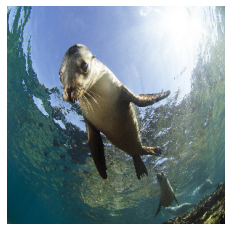

Image Shape: (300, 300, 3)
sea_lions
Numerical Label Shape: ()


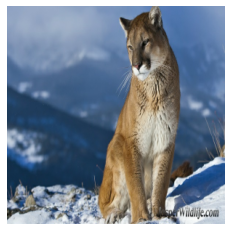

Image Shape: (300, 300, 3)
cougar
Numerical Label Shape: ()


In [19]:
for img, label in parsed_dataset_train.take(1):
  plt.imshow(img) 
  plt.axis('off') 
  plt.show()
  print(f'Image Shape: {img.shape}')
  print(index_to_label[label.numpy()])
  print(f'Numerical Label Shape: {label.shape}')

for img, label in parsed_dataset_val.take(1):
  plt.imshow(img) 
  plt.axis('off') 
  plt.show()
  print(f'Image Shape: {img.shape}')
  print(index_to_label[label.numpy()])
  print(f'Numerical Label Shape: {label.shape}')

# Preprocessing Image

In [20]:
def distort_img(img, label):
  distort_img = tf.image.random_brightness(img, max_delta=63)
  distort_img = tf.image.random_contrast(distort_img, lower=0.2, upper=1.8)
  distort_img = tf.image.per_image_standardization(distort_img)
#   distort_img = tf.image.per_image_standardization(img)
  # distort_img = img

#   # image must be scaled in [0, 1]
  with tf.name_scope('Add_gaussian_noise'):
      noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
      noise_img = distort_img + noise
      noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)

  return noise_img, label

def ohe_label(img, label):
  label = tf.one_hot(label,n_classes)
  return img, label

def flip_lr_img(img, label):
  return tf.image.flip_left_right(img), label

def flip_ud_img(img, label):
  return tf.image.flip_up_down(img), label

def rand_crop_img(img, label):
  return tf.image.random_crop(img, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, 3]), label

In [21]:
pre_dataset_train = parsed_dataset_train
pre_dataset_train = pre_dataset_train.concatenate(
    pre_dataset_train.map(flip_lr_img)).concatenate(
    pre_dataset_train.map(flip_ud_img)).concatenate(
    pre_dataset_train.map(flip_lr_img).map(flip_ud_img))
# pre_dataset_train = pre_dataset_train.repeat(5)
pre_dataset_train = pre_dataset_train.map(distort_img)
pre_dataset_train = pre_dataset_train.map(rand_crop_img)

# pre_dataset_val = parsed_dataset_val.map(distort_img)
pre_dataset_val = parsed_dataset_val
pre_dataset_val = pre_dataset_val.map(rand_crop_img)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


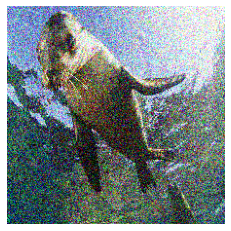

Image Shape: (224, 224, 3)
sea_lions
Numerical Label Shape: ()


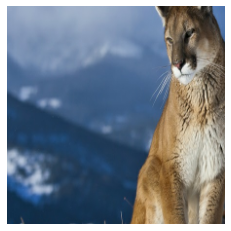

Image Shape: (224, 224, 3)
cougar
Numerical Label Shape: ()


In [40]:
for img, label in pre_dataset_train.take(1):
  plt.imshow(img) 
  plt.axis('off') 
  plt.show()
  print(f'Image Shape: {img.shape}')
  print(index_to_label[label.numpy()])
  print(f'Numerical Label Shape: {label.shape}')

for img, label in pre_dataset_val.take(1):
  plt.imshow(img) 
  plt.axis('off') 
  plt.show()
  print(f'Image Shape: {img.shape}')
  print(index_to_label[label.numpy()])
  print(f'Numerical Label Shape: {label.shape}')

# Shuffle and Batch

In [41]:
# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [42]:
pre_dataset_train = pre_dataset_train.shuffle(BUFFER_SIZE)
pre_dataset_train = pre_dataset_train.batch(BATCH_SIZE)
dataset_train_fin = pre_dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

pre_dataset_val = pre_dataset_val.batch(BATCH_SIZE)
dataset_val_fin = pre_dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Train VGG16

In [43]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.BatchNormalization())
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.BatchNormalization())
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(10, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [44]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train_fin, validation_data=dataset_val_fin, epochs=5)

Epoch 1/5
359/359 [==============================] - 259s 722ms/step - loss: 1.6293 - accuracy: 0.5267 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
359/359 [==============================] - 309s 862ms/step - loss: 1.0748 - accuracy: 0.6555 - val_loss: 2.0222 - val_accuracy: 0.5781
Epoch 3/5
359/359 [==============================] - 308s 857ms/step - loss: 0.8836 - accuracy: 0.7064 - val_loss: 2.0811 - val_accuracy: 0.5488
Epoch 4/5
359/359 [==============================] - 313s 872ms/step - loss: 0.7963 - accuracy: 0.7321 - val_loss: 1.9313 - val_accuracy: 0.5732
Epoch 5/5
359/359 [==============================] - 276s 769ms/step - loss: 0.7385 - accuracy: 0.7530 - val_loss: 2.5450 - val_accuracy: 0.5572
